# Compare Snow depth Maps Example

**Goal**: Use the USGS Snow off and the ASO snow off to calculate a snow depth raster. Compare them.

**Approach**: 

1. Get a location and make a perimeter
2. 

## Process:

### Step 1: Get a buffered circle centered on a pit

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, SiteData
from rasterio.plot import show

from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio, points_to_geopandas, query_to_geopandas, crop, resample
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import rasterio.mask
import tempfile
from matplotlib.image import AxesImage

# Pit Site Identifier of interest
site_id = '1S1'

# Distance around the pit to collect data in meters
buffer_dist = 100

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_id==site_id)
sites = q.all()

# Grab the pit location from a single layer
p = to_shape(sites[0].geom)

# Build a polygon  using the buffer distance 
x1 = p.x - buffer_dist
y1 = p.y - buffer_dist
x2 = p.x + buffer_dist
y2 = p.y + buffer_dist
buffer_shp = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
buffered_pit = from_shape(buffer_shp, srid=26912).ST_AsEWKT()
buffered_pit_df = gpd.GeoDataFrame({'geometry':[buffer_shp, p]})

### Step 2. Gather the Snow on/off rasters within the Buffered Pit 

In [2]:
# Grab the rasters, union them and convert them as tiff when done
# Grab the snow on from QSI
s = func.ST_Clip(gfunc.ST_Union(ImageData.raster, type_=Raster), buffered_pit)

# Return the Polygon of the boundary and the raster
q = session.query(func.ST_Envelope(s), func.ST_AsTiff(s))

# Filter by the name
q = q.filter(ImageData.type == 'bare earth digital elevation models')

# Filter to QSI
q = q.filter(ImageData.surveyors == 'Quantum Spatial Inc.')

# Only grab the tiles in the buffered pit
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffered_pit))
records = q.all()

# Get the shape of the raster boundary
snow_on_boundary = to_shape(records[0][0])
boundary_EWKT = from_shape(snow_on_boundary, srid=26912).ST_AsEWKT()

# Convert the resulting image to a rasterio dataset
rasters = [[records[0][1]]]
snow_on = raster_to_rasterio(session, rasters)[0]
print('QSI raster {} X {} Res = {}x{}'.format(snow_on.width, snow_on.height, snow_on.res[0], snow_on.res[1]))

# Retrieve the original resolution 
q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
res = q.filter(ImageData.type == 'bare earth digital elevation models').filter(ImageData.surveyors == 'Quantum Spatial Inc.').limit(1).all()
print('Original Resolution = {} x {}'.format(res[0][0], res[0][1]))

print(snow_on.bounds)

QSI raster 400 X 400 Res = 0.5x0.5
Original Resolution = 0.5 x 0.5
BoundingBox(left=741820.0, bottom=4322745.0, right=742020.0, top=4322945.0)


In [3]:
# Get the snow off from ASO
session.rollback()

def retrieve_matched_raster(data_name, surveyors, polygon, res):
    '''
    Gather all rasters filted by name and surveyors that intersect the polygon. Resample to the resolution provided
    and clip to the polygon
    '''
    # Retrieve the original resolution 
    q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
    res_o = q.filter(ImageData.type == data_name).filter(ImageData.surveyors == surveyors).limit(1).all()
    print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))
    
    # Return a Tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
    s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster, type_=Raster), res[0], -1 * res[1],  algorithm='Bilinear'), polygon)

    # Filter by surveyors and data name DEM
    q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    # Grab all tile that intersect the snow on boundary
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))
    records = q.all()

    # Convert to Rasterio 
    dataset = raster_to_rasterio(session, records)[0]
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)
    return dataset


USGS:
Original Resolution = 1.0 x1.0
Raster 400 X 400, Final Res = 0.5 x 0.5
BoundingBox(left=741820.0, bottom=4322745.0, right=742020.0, top=4322945.0)


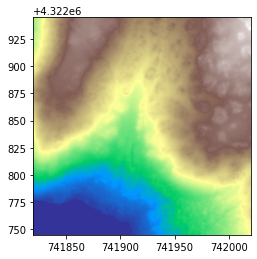


ASO:
Original Resolution = 2.999870551816784 x2.999870551816784
Raster 401 X 401, Final Res = 0.5 x 0.5
BoundingBox(left=741819.7561938388, bottom=4322744.707817027, right=742020.2561938388, top=4322945.207817027)


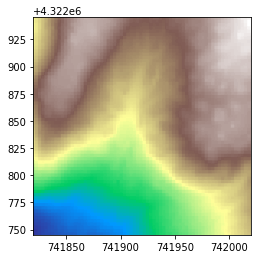

In [4]:
# Return a Tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
print('\nUSGS:')
usgs_snow_off = retrieve_matched_raster('snow off digital elevation model', 'USGS', boundary_EWKT, snow_on.res)
usgs = usgs_snow_off.read(1)
show(usgs, transform = usgs_snow_off.transform, cmap='terrain')

print('\nASO:')
aso_snow_off = retrieve_matched_raster('snow off digital elevation model', 'Airborne Snow Observatory', boundary_EWKT, snow_on.res)
aso = aso_snow_off.read(1)[0:usgs.shape[0], 0:usgs.shape[1]]
nan_ind = aso == -9999
aso[nan_ind] = np.nan
show(aso, transform=aso_snow_off.transform, cmap='terrain')


Difference Map:
	mean = 16.73337173461914
	min = 16.38720703125
	max = 17.97509765625
	std = 0.14462973177433014


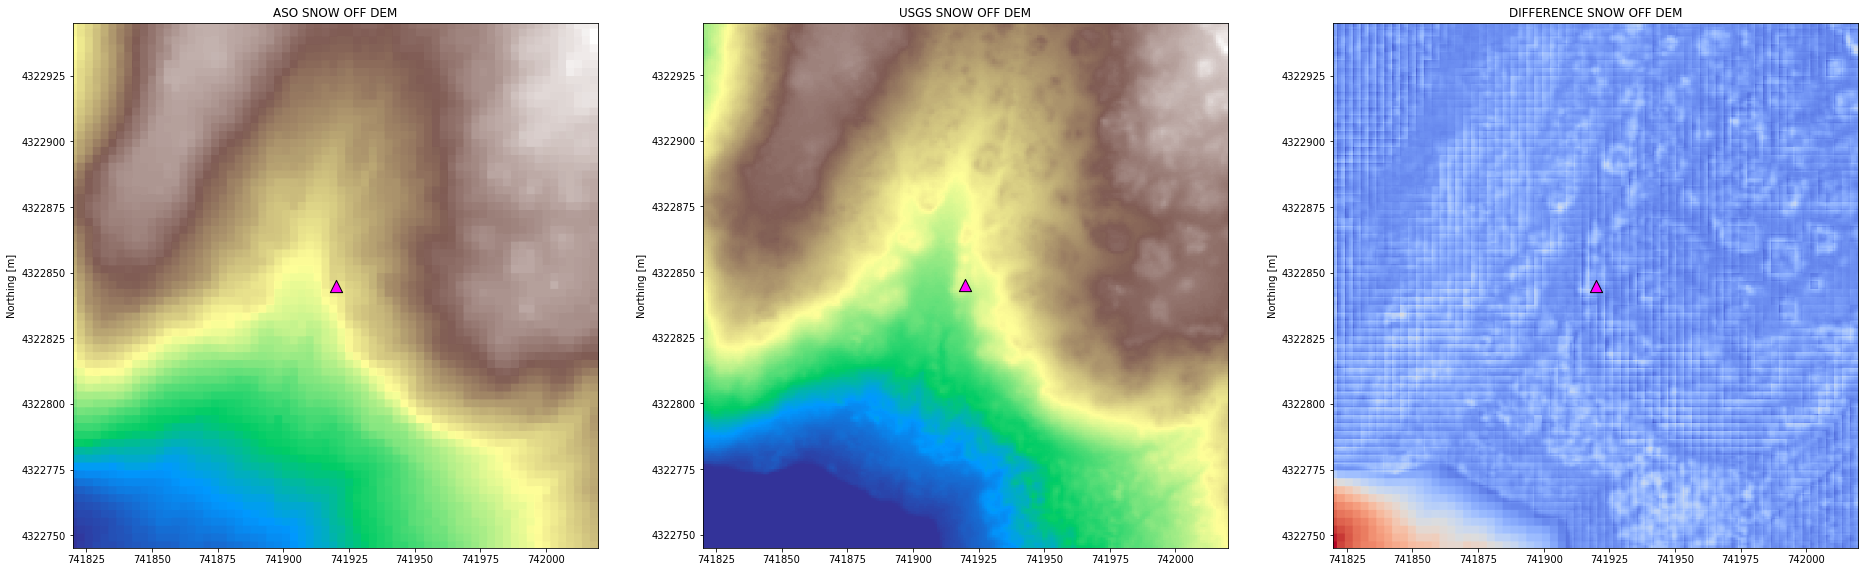

In [5]:
# Plot these to confirm we have something similar
rasters = {'aso':(aso, aso_snow_off.transform), 
           'usgs':(usgs, usgs_snow_off.transform),
           'difference': (usgs - aso, aso_snow_off.transform)}

fig, axes = plt.subplots(1,len(rasters.keys()), figsize=(32, 16))
i = 0 

for name, dst in rasters.items():
    if name == 'difference':
        cmap = 'coolwarm'
        print('Difference Map:')
        for stat in ['mean', 'min', 'max','std']:
            result = getattr(dst[0], stat)()
            print('\t{} = {}'.format(stat, result))
            
    elif name == 'QSI':
        cmap = 'PuBu'
    else:
        cmap = 'terrain'
    # pic = axes[i].imshow(img[0], cmap=cmap)
    # fig.colorbar(pic, ax=axes[i])
    #im = axes[i].imshow(img[0], cmap=cmap, interpolation=None)
    show(dst[0], transform=dst[1], cmap=cmap, ax=axes[i])
    
    # Don't use scientific notation on the axis ticks
    axes[i].ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    axes[i].set_ylabel('Northing [m]')
    axes[i].set_title('{} SNOW OFF DEM'.format(name.upper()))
    buffered_pit_df.iloc[1:].plot(ax=axes[i], marker='^', color='magenta',  markersize=150, edgecolor='black')
    i += 1
plt.savefig('/home/micah/Pictures/DEM_comparison.png')
# fig.colorbar(im, ax=axes.ravel().tolist())


rasters['QSI'] = (snow_on.read(1), snow_on.transform)

### Step . Create the Snow Depth Maps

In [6]:
snow_dem = rasters['QSI'][0]

usgs_depths = snow_dem - rasters['usgs'][0]
aso_depths = snow_dem - rasters['aso'][0]

diff = aso_depths - usgs_depths

### Step 5. Plot it

No handles with labels found to put in legend.
No handles with labels found to put in legend.


usgs
	mean = 0.7154524922370911
	min = -0.659912109375
	max = 1.3359375
	std = 0.20145462453365326
aso
	mean = 17.44882583618164
	min = 16.79638671875
	max = 18.086181640625
	std = 0.15264691412448883


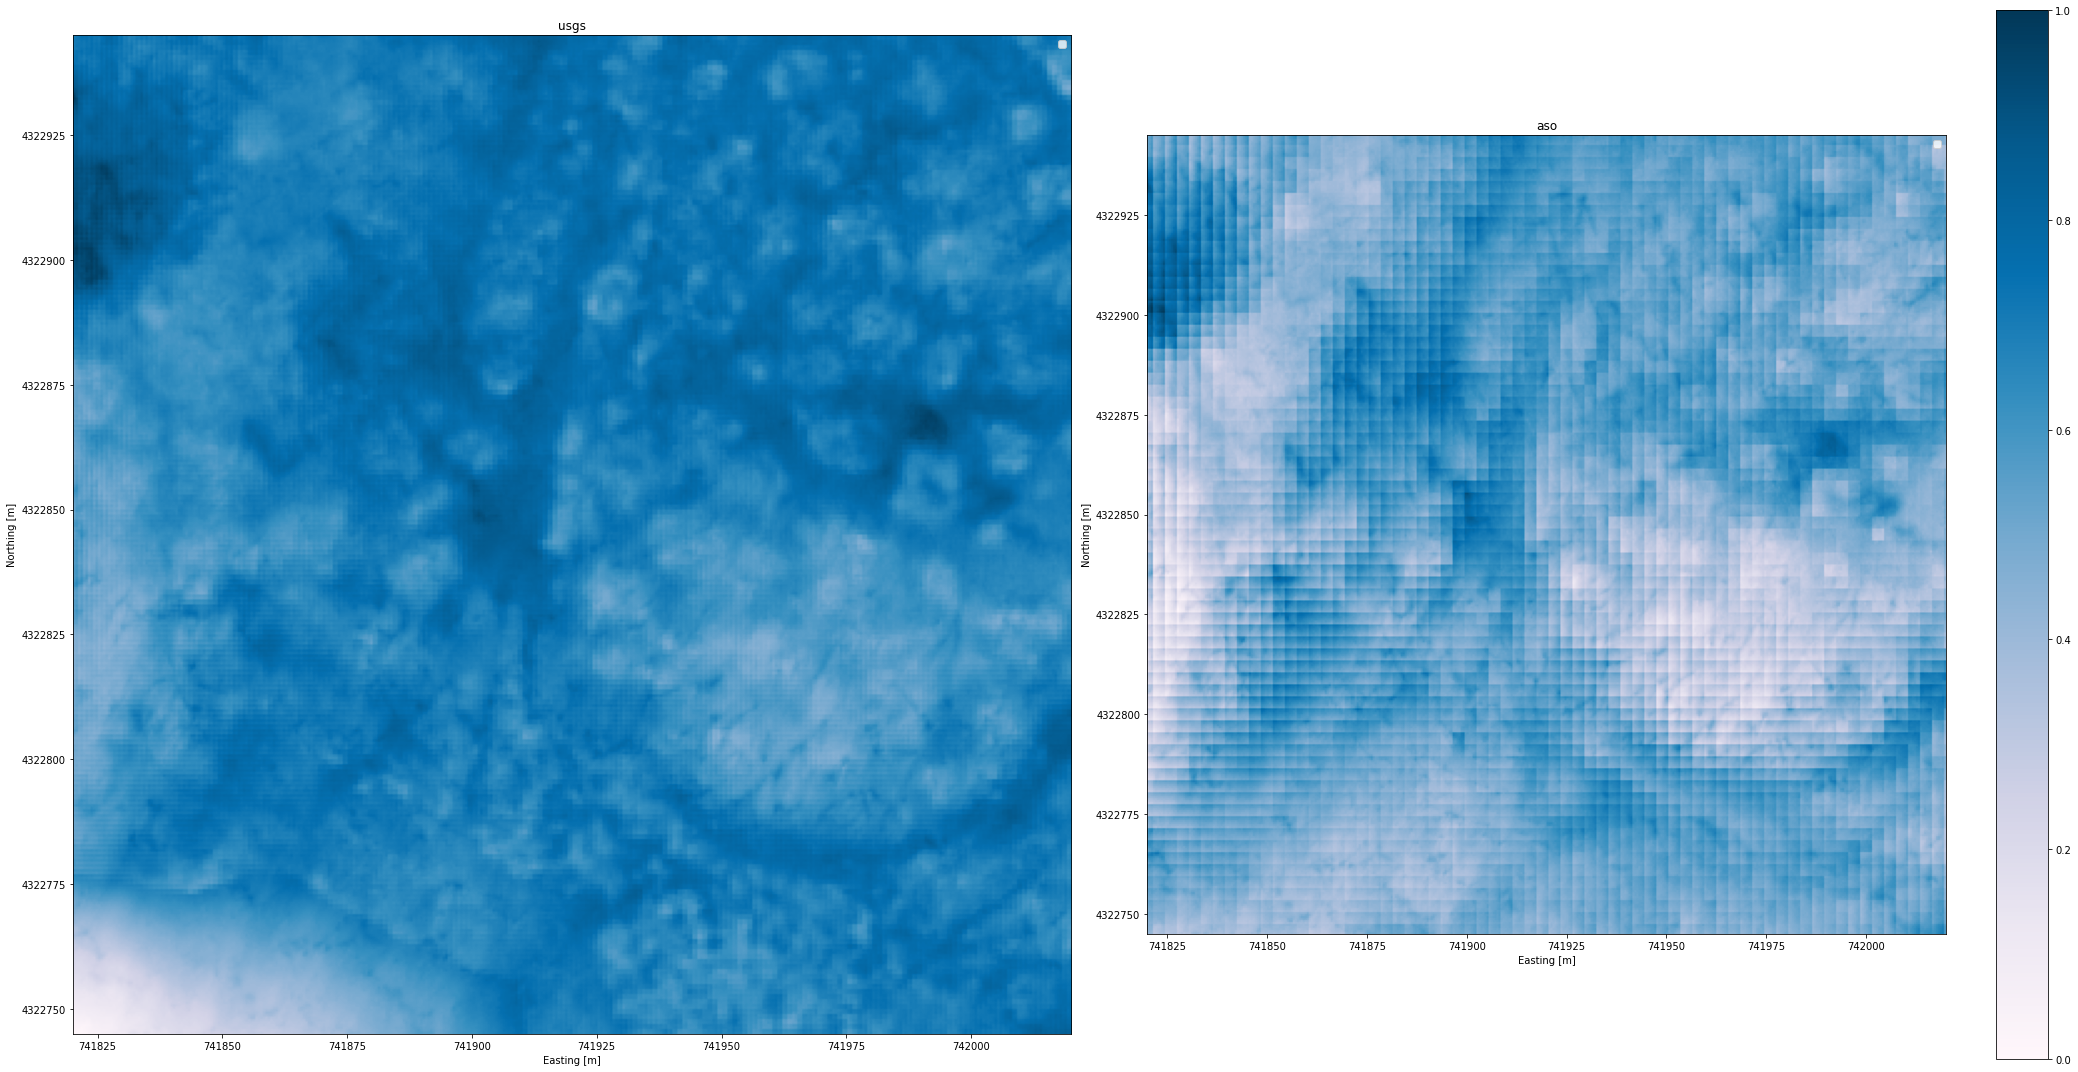

In [7]:
# Create a single plot to add everything to
data = {'usgs': usgs_depths, 'aso':aso_depths}

h = 15
nplots = len(data.keys())
fig, axes = plt.subplots(1, nplots, figsize=(2 * h, h))

i = 0 

cmap = 'PuBu'

# Plot the Snow Depths
for name, d in data.items():
    img = d
    ax = axes[i]

    ax = show(img, ax=ax, cmap=cmap, transform=snow_on.transform)
    
    print(name)
    for stat in ['mean','min','max','std']:
        print('\t{} = {}'.format(stat, getattr(img, stat)()))
    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(name)
    ax.legend()

    i += 1
    
img = AxesImage(ax, cmap=cmap)
bar = fig.colorbar(img)    
plt.tight_layout()


In [8]:
session.close()
